# __Zarządzanie ryzykiem w firmie NVIDIA__

Szymon Malec <br>
Michał Wiktorowski <br>
Filip Oszczepaliński <br>
Damian Szuster

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import stdev
from scipy.stats import median_abs_deviation, skew, kurtosis, pearsonr, norm, logistic, laplace, kstest
from scipy.special import erf
import seaborn as sns; sns.set()

In [68]:
def equalize(df): #funkcja ta skaluje ceny miedzi do cen za tonę
    d = 2204.623
    col_names = [col for col in df.columns][1:]
    col_names.remove('Volume')
    for name in col_names:
        df[name] = df[name]*d
    return df

def draw_stock(df, clr, title): #funkcja rysuje wykres cen
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1]
    prices = df['Open'].values[::-1]
    plt.plot(dates, prices, color = clr)
    plt.ylabel('USD')
    plt.title(title)
    plt.show()
    
def draw_ret(df, clr, title): #funkcja rysuje wykres log stóp zwrotu
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1][:-1]
    prices1 = df['Open'].values[::-1][1:]
    prices2 = df['Open'].values[::-1][:-1]
    r = np.log(prices1/prices2)
    plt.plot(dates, r, color = clr, lw=1)
    plt.ylabel('USD')
    plt.title(title)
    plt.show()

#Porównanie histogramu z wykresami funkcji gęstości
def norm_kde(x, best_fit = None):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    x = np.array(sorted(x))
    mi = np.mean(x)
    sigma = stdev(x)
    
    plt.hist(x, bins = 50, density = True, color = 'white', ec = 'black')
    y = norm.pdf(x, mi, sigma) #rozkład normalny
    plt.plot(x, y, color = 'blue', label = 'normal pdf')
    if best_fit == logistic:
        y2 = logistic.pdf(x, mi, math.sqrt(3)/math.pi*sigma) #rozkład logistyczny
        plt.plot(x, y2, color = 'red', label = 'logistic pdf')
    if best_fit == laplace:
        y2 = laplace.pdf(x, mi, 1/np.sqrt(2) * sigma)
        plt.plot(x, y2, color = 'red', label = 'laplace pdf')   
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.show()

def comp_quantile(x, p1, p2, p3): #p ma być z zakresu [0, 1]
    mi = np.mean(x)
    sigma = stdev(x)
    p = [p1, p2, p3]
    real = np.quantile(x, p)
    nrm = norm.ppf(p, mi, sigma)
    lgstc = logistic.ppf(p, mi, math.sqrt(3)/math.pi*sigma)
    perc = [format(p, '.2%') for p in [p1, p2, p3]]
    dct = {'p' : perc, 'real' : real, 'normal' : nrm, 'logistic' : lgstc}
    df = pd.DataFrame(dct)
    return df

#Porównanie dystrybuant teoretycznych z dystrybuantą empiryczną
def cdf(x, best_fit = None, port = False):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    x = np.array(sorted(x))
    mi = np.mean(x)
    sigma = stdev(x)
    
    sns.ecdfplot(data = x, color = 'blue', label = 'ECDF', linestyle = 'dashdot')
    if port == True:
        y = norm.cdf(x, mi, sigma)
        plt.plot(x, y, color = 'black', label = 'norm cdf', lw = .7)

    if best_fit == logistic:
        y2 = logistic.cdf(x, mi, math.sqrt(3)/math.pi*sigma) #rozkład logistyczny
        plt.plot(x, y2, color = 'red', label = 'logistic cdf', lw = .7)
    if best_fit == laplace:
        y2 = laplace.cdf(x, mi, 1/np.sqrt(2) * sigma)
        plt.plot(x, y2, color = 'red', label = 'laplace cdf', lw = .7)   

    plt.xlabel('x')
    plt.ylabel('F(x)')
    plt.legend()
    plt.show()

def comp_dist(x, x0 = [-0.05, -0.03, -0.01, 0, 0.01, 0.03, 0.05]):
    x = sorted(x)
    mi = np.mean(x)
    sigma = stdev(x)
    #real = [np.linspace(0, 1, len(x))]
    nrm = norm.cdf(x0, mi, sigma)
    lgstc = logistic.cdf(x0, mi, sigma)
    dct = {'x0' : x0, 'normal' : nrm, 'logistic' : lgstc}
    df = pd.DataFrame(dct)
    return df

__Zmienne ryzyka__:
- Ceny miedzi
- Ceny aluminium

# Miedź

In [4]:
copper_ = pd.read_csv('data/copper.csv', sep = ',', encoding = 'latin-1')
copper = equalize(copper_) #ceny miedzi przeskalowane do ton

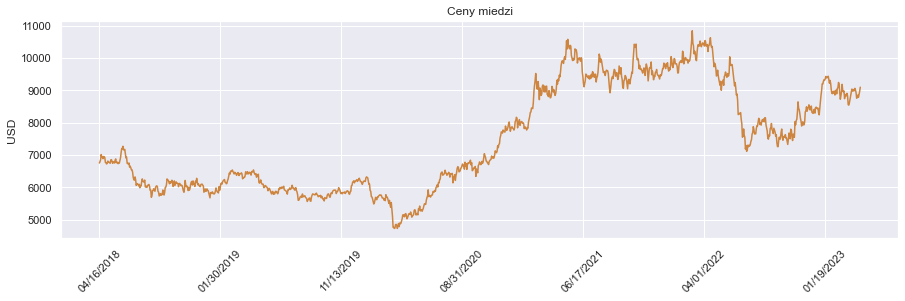

In [5]:
draw_stock(copper, 'peru', 'Ceny miedzi')

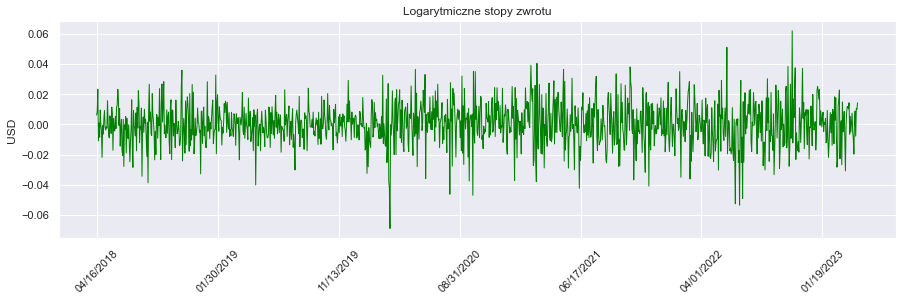

In [6]:
s = np.array(copper['Open'].values)
r = np.log(s[1:]/s[:-1])
draw_ret(copper, 'green', 'Logarytmiczne stopy zwrotu')

In [7]:
print('Średnia: ' + str(np.mean(r)))
print('Wariancja: ' + str(np.var(r)))
print('Odchylenie standardowe: ' + str(len(r)/(len(r)+1) * stdev(r)))
print('Odchylenie przeciętne: ' + str(median_abs_deviation(r)))
print('Odchylenie ćwiartkowe: ' + str(0.5*(np.quantile(r, .75) - np.quantile(r, .25))))
print('Skośność: ' + str(skew(r)))
print('Kurtoza: ' + str(kurtosis(r)))
print('Pierwszy kwartyl: ' + str(np.quantile(r, .25)))
print('Mediana: ' + str(np.quantile(r, .5)))
print('Trzeci kwartyl: ' + str(np.quantile(r, .75)))

Średnia: -0.0002367193970863344
Wariancja: 0.00020321096766212561
Odchylenie standardowe: 0.014249554983119849
Odchylenie przeciętne: 0.008379502169224238
Odchylenie ćwiartkowe: 0.008443862670245503
Skośność: 0.17440041345123358
Kurtoza: 1.184339957347377
Pierwszy kwartyl: -0.00903230848294452
Mediana: -0.0001925113106339907
Trzeci kwartyl: 0.007855416857546486


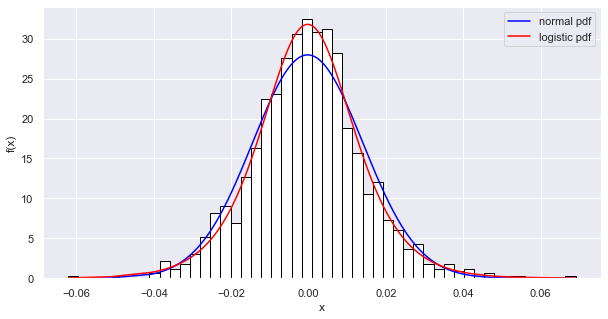

In [8]:
norm_kde(r, logistic)

In [9]:
kstest(r, 'logistic', [np.mean(r), np.sqrt(3)/np.pi * np.std(r)])

KstestResult(statistic=0.017453199466375247, pvalue=0.8311462591278722)

In [10]:
comp_quantile(r, .95, .975, .99)

,p,real,normal,logistic
0,95.00%,0.023471,0.023220,0.022914
1,97.50%,0.028709,0.027714,0.028568
2,99.00%,0.037609,0.032939,0.035892


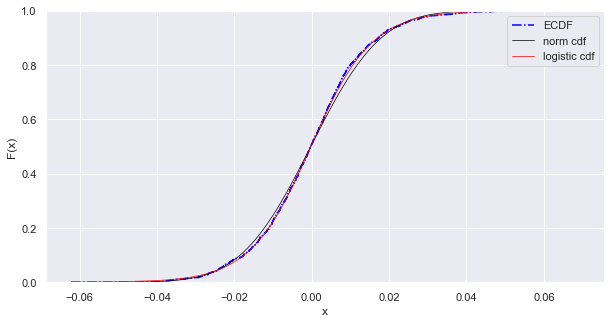

In [11]:
cdf(r, logistic)

In [12]:
comp_dist(r)

,x0,normal,logistic
0,-0.05,0.000242,0.029613
1,-0.03,0.018441,0.110361
2,-0.01,0.246792,0.335231
3,0.00,0.506622,0.504150
4,0.01,0.763565,0.672126
5,0.03,0.983008,0.892857
6,0.05,0.999786,0.971327


# Aluminium

In [13]:
aluminium = pd.read_csv('data/aluminium.csv', sep = ',', encoding = 'latin-1')   # ceny aluminium (przed ucięciem)

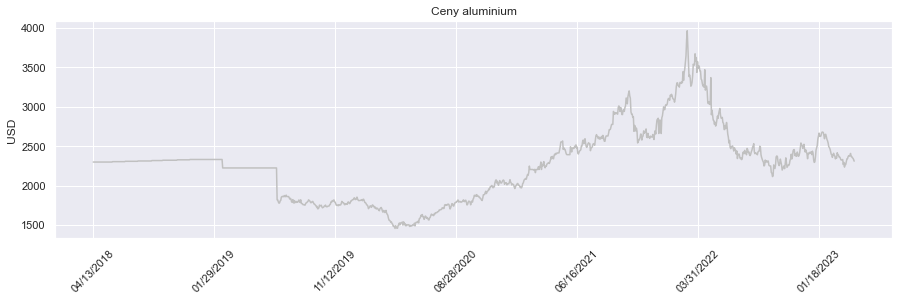

In [14]:
draw_stock(aluminium, 'silver', 'Ceny aluminium')

In [15]:
idx = aluminium.index[aluminium['Date'] == '07/01/2019'].tolist()[0]
idx # idx = 952
aluminium2 = aluminium.drop(aluminium.index[idx:1259]) #ceny aluminium (po ucięciu)

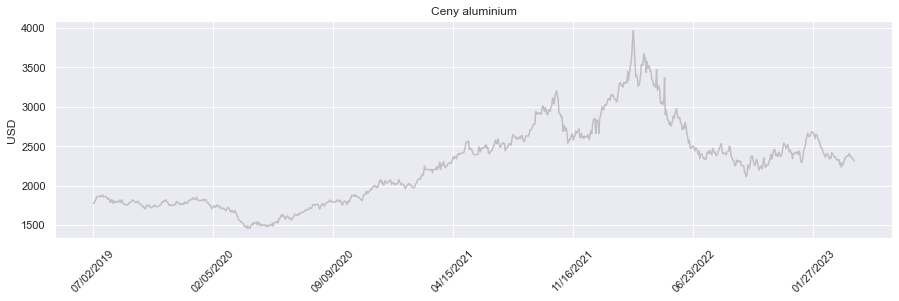

In [16]:
draw_stock(aluminium2, 'silver', 'Ceny aluminium')

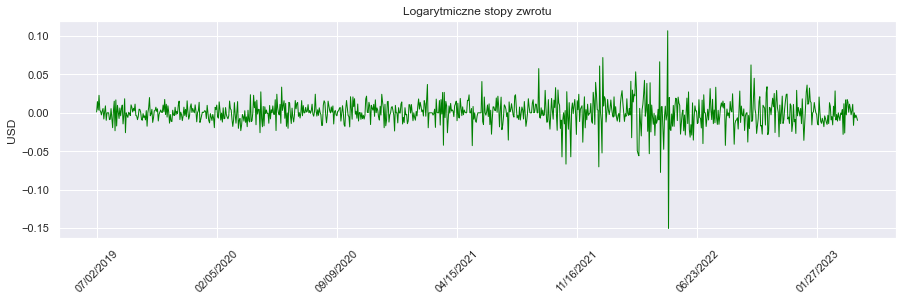

In [17]:
s_ = np.array(aluminium2['Open'].values)
r2 =  np.log(s_[1:]/s_[:-1])
draw_ret(aluminium2, 'green', 'Logarytmiczne stopy zwrotu')

In [18]:
print('Średnia: ' + str(np.mean(r2)))
print('Wariancja: ' + str(np.var(r2)))
print('Odchylenie standardowe: ' + str(len(r2)/(len(r2)+1) * stdev(r2)))
print('Odchylenie przeciętne: ' + str(median_abs_deviation(r2)))
print('Odchylenie ćwiartkowe: ' + str(0.5*(np.quantile(r2, .75) - np.quantile(r2, .25))))
print('Skośność: ' + str(skew(r2)))
print('Kurtoza: ' + str(kurtosis(r2)))
print('Pierwszy kwartyl: ' + str(np.quantile(r2, .25)))
print('Mediana: ' + str(np.quantile(r2, .5)))
print('Trzeci kwartyl: ' + str(np.quantile(r2, .75)))

Średnia: -0.0002754048568726295
Wariancja: 0.00027281978602528673
Odchylenie standardowe: 0.016508589036051853
Odchylenie przeciętne: 0.008324835433568057
Odchylenie ćwiartkowe: 0.008352027059498843
Skośność: 0.688756968721271
Kurtoza: 11.012603187743872
Pierwszy kwartyl: -0.008764626707863613
Mediana: 0.0
Trzeci kwartyl: 0.007939427411134074


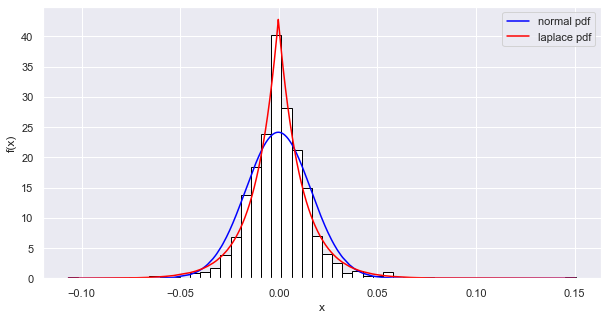

In [19]:
norm_kde(r2, laplace)

In [20]:
kstest(r2, 'laplace', [np.mean(r), 1/np.sqrt(2) * np.std(r)])

KstestResult(statistic=0.03997019263806101, pvalue=0.09323378909182489)

In [21]:
comp_quantile(r2, .95, .975, .99)

,p,real,normal,logistic
0,95.00%,0.023344,0.026907,0.026552
1,97.50%,0.031319,0.032115,0.033104
2,99.00%,0.050773,0.038170,0.041592


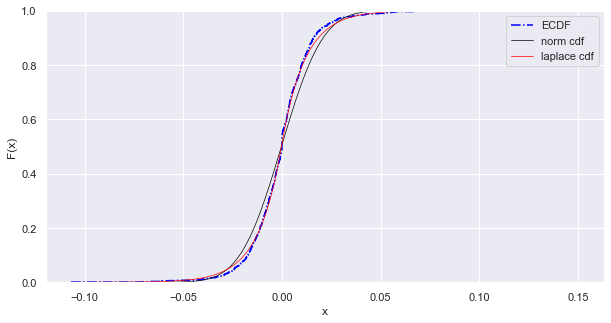

In [22]:
cdf(r2, laplace)

In [23]:
comp_dist(r2)

,x0,normal,logistic
0,-0.05,0.001311,0.047026
1,-0.03,0.036036,0.142014
2,-0.01,0.278117,0.356992
3,0.00,0.506648,0.504166
4,0.01,0.732955,0.650622
5,0.03,0.966524,0.861999
6,0.05,0.998826,0.954445


# PRZYPADEK WIELOWYMIAROWY

In [30]:
idx = 952 #liczone przy aluminium
stock1 = copper['Open'].values[:idx][::-1]
stock2 = aluminium['Open'].values[:idx][::-1]
s = np.array(stock1[1:])
s2 = np.array(stock1[:-1])
r1 = np.log(s/s2)
s_ = np.array(stock2[1:])
s2_ = np.array(stock2[:-1])
r2 =  np.log(s_/s2_)

#funkcja tworzy portfel z dwóch zmiennych ryzyka - w1 i w2 to wagi portfela
def portfolio(x1, x2, w1, w2):
    try:
        x = w1*x1 + w2*x2
    except ValueError:
        print('Rozmiary próbek muszą być równe!')
    return x

# zwroty logarytmiczne portfela (jakie wagi bierzemy ???)
port = portfolio(r1, r2, 1/3, 2/3)

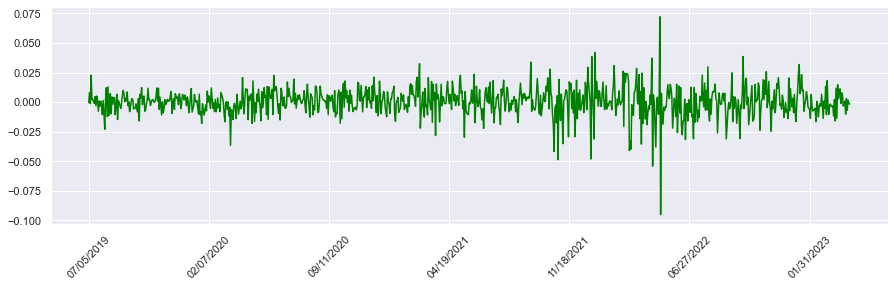

In [61]:
fig, ax = plt.subplots(figsize = (15, 4))
plt.xticks(rotation = 45)
xloc = plt.MaxNLocator(9)
ax.xaxis.set_major_locator(xloc)
dates = copper['Date'].values[1:idx][::-1]
plt.plot(dates, port, color = 'green')
plt.show()

Text(0, 0.5, '')

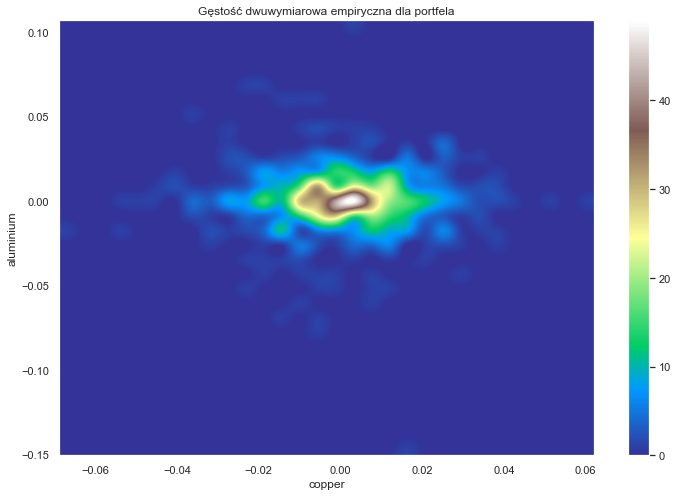

In [62]:
heatmap, xedges, yedges = np.histogram2d(r1, r2, bins = 30)

fig = plt.figure(figsize = (12, 8))
plt.imshow(heatmap.T, interpolation="spline36", 
               cmap = 'terrain',
              extent = [min(xedges), max(xedges),
                       min(yedges), max(yedges)],
          aspect = 'auto',
          origin = 'lower')
plt.grid(visible = False)
plt.xlabel('copper')
plt.ylabel('aluminium')
plt.title('Gęstość dwuwymiarowa empiryczna dla portfela')
cbar = plt.colorbar()
cbar.ax.set_ylabel('')

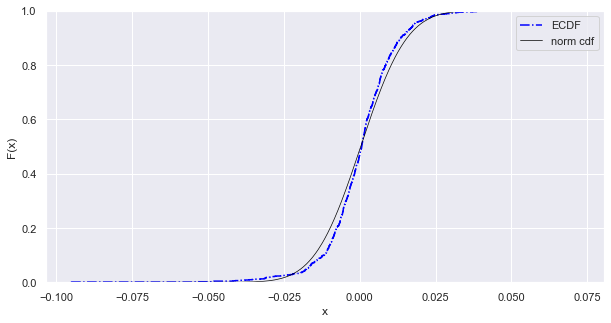

In [58]:
cdf(port, True)

In [66]:
def cdf_2d(x, y):
    try:
        heatmap = np.zeros((len(x), len(y)))
        x_ = np.linspace(min(x), max(x), len(x))
        y_ = np.linspace(min(y), max(y), len(y))
        for i in range(len(x)):
            for j in range(len(y)):
                heatmap[i][j] = len(x[x < x_[i]])/len(x)*len(y[y < y_[j]])/len(y)
        fig = plt.figure(figsize = (12, 8))
        plt.imshow(heatmap.T, interpolation="spline36", 
                       cmap = 'Greens',
                      extent = [min(x), max(x),
                               min(y), max(y)],
                  aspect = 'auto',
                  origin = 'lower')
        plt.grid(visible = False)
        plt.xlabel('copper')
        plt.ylabel('aluminium')
        cbar = plt.colorbar()
        cbar.ax.set_ylabel('')
        plt.title('Dystrybuanta dwuwymiarowa empiryczna dla portfela')
        plt.show()
    except ValueError:
        print('Różne rozmiary prób!')

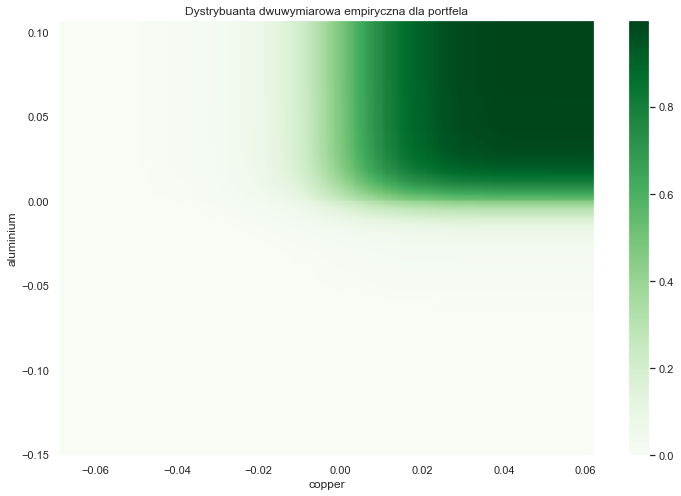

In [67]:
cdf_2d(r1, r2)